In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns

In [11]:
# Define file path of the dataset
file_path = 'socio_demo.csv'

# Create dataframe
df_socio_demo = pd.read_csv(file_path)

display(df_socio_demo.head(10))

,customer_id,breed,age,income
0,rezLh5Hae3m6flaxM4,Purebred,[25-35[,[120-200K$[
1,resWkHpEcL1IUfdoBp,Purebred,[25-35[,[80-120K$[
2,re9qxF7kS9R2LwOVVY,Purebred,[35-45[,[80-120K$[
3,re3IZNYZY6xr8OAE56,Purebred,[55-65[,[40-80K$[
4,re01lnV2DfgMLdfIF7,Purebred,[65+[,[80-120K$[
5,re9NBi5sPGveUW6zqc,Purebred,[55-65[,[40-80K$[
6,reKZWGlcyUPLC9snc1,Purebred,[55-65[,[200K$+[
7,recNuyd3xuHemzComz,Mixed-breed,[55-65[,[80-120K$[
8,resmVwWh8SLjQbnsJf,Purebred,[18-25[,[120-200K$[
9,reb1EYLdxtmIQ3RcP5,Mixed-breed,[65+[,[80-120K$[


In [12]:
print(len(df_socio_demo))

1354584


In [13]:
# Display basic information about the dataset
print("\nBasic Information:\n")
df_socio_demo.info()

# Display summary statistics
print("\nSummary Statistics:\n")
print(df_socio_demo.describe(include='all'))


Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354584 entries, 0 to 1354583
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1354584 non-null  object
 1   breed        1354584 non-null  object
 2   age          1354584 non-null  object
 3   income       1354584 non-null  object
dtypes: object(4)
memory usage: 41.3+ MB

Summary Statistics:

               customer_id     breed      age       income
count              1354584   1354584  1354584      1354584
unique             1354584         2        6            5
top     rezLh5Hae3m6flaxM4  Purebred    [65+[  [120-200K$[
freq                     1    827017   257005       297276


# Missing Values

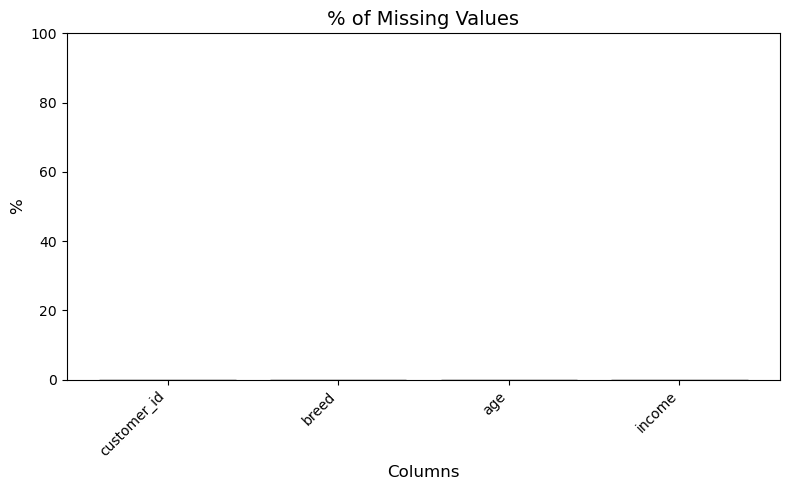

             Missing Count  Missing Percentage (%)
customer_id              0                     0.0
breed                    0                     0.0
age                      0                     0.0
income                   0                     0.0


In [14]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    
    # Create the histogram
    plt.figure(figsize=(8, 5))
    plt.ylim(0, 100)
    plt.bar(missing_summary.index, missing_summary['Missing Percentage (%)'], color='skyblue', edgecolor='black')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('%', fontsize=12)
    plt.title('% of Missing Values', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return missing_summary

# Example usage
summary = count_missing_values_summary(df_socio_demo)
print(summary)

Text(0, 0.5, 'Percentage')

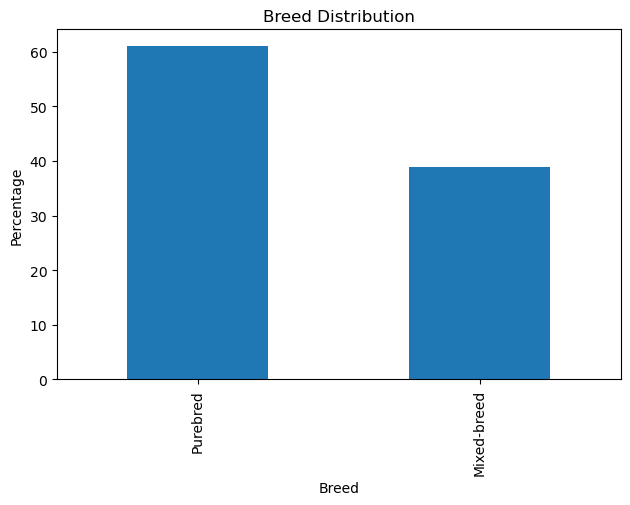

In [15]:
# Plot distributions for each column
plt.figure(figsize=(16, 10))

# Breed distribution
plt.subplot(2, 2, 1)
(df_socio_demo['breed'].value_counts(normalize=True) * 100).plot(kind='bar')
plt.title('Breed Distribution')
plt.xlabel('Breed')
plt.ylabel('Percentage')

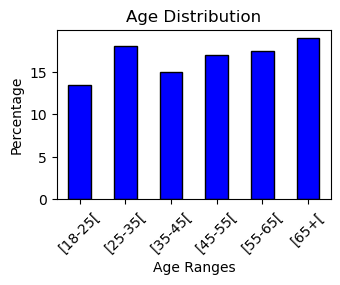

In [16]:
# Convert age ranges into categorical data
age_counts = df_socio_demo['age'].value_counts(normalize=True) * 100  # Convert to percentages

# Plot age distribution as a bar chart
plt.subplot(2, 2, 2)
age_counts.sort_index().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age Ranges')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '[0-40K$['),
  Text(1, 0, '[40-80K$['),
  Text(2, 0, '[80-120K$['),
  Text(3, 0, '[120-200K$['),
  Text(4, 0, '[200K$+[')])

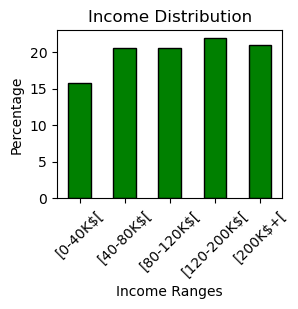

In [17]:
# Income distribution
plt.subplot(2, 2, 3)
income_counts = df_socio_demo['income'].value_counts(normalize=True) * 100
income_counts = income_counts.reindex(sorted(income_counts.index, key=lambda x: float(x.strip('[]$K+').split('-')[0].replace('K$', '').replace('+', '').replace('$', '').replace('K', ''))))  # Sort ranges
income_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income Ranges')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

In [19]:
# Convert age ranges to numeric midpoints
def convert_age_to_midpoint(age_range):
    age_range = age_range.strip('[]')  # Remove brackets
    if '+' in age_range:  # Handle cases like '65+'
        lower = int(age_range.replace('+', ''))  # Convert '65+' to 65
        return lower  # Return the lower bound or another fixed value
    else:
        lower, upper = map(int, age_range.split('-'))
        return (lower + upper) / 2  # Calculate the midpoint

# Apply the conversion
df_socio_demo['age_midpoint'] = df_socio_demo['age'].apply(convert_age_to_midpoint)

# Verify the transformation
print(df_socio_demo[['age', 'age_midpoint']])


             age  age_midpoint
0        [25-35[          30.0
1        [25-35[          30.0
2        [35-45[          40.0
3        [55-65[          60.0
4          [65+[          65.0
...          ...           ...
1354579  [18-25[          21.5
1354580  [35-45[          40.0
1354581    [65+[          65.0
1354582  [35-45[          40.0
1354583  [18-25[          21.5

[1354584 rows x 2 columns]


In [20]:
df_socio_demo_cleaned = df_socio_demo
df_socio_demo_cleaned.shape

(1354584, 5)

In [21]:
display(df_socio_demo_cleaned)

,customer_id,breed,age,income,age_midpoint
0,rezLh5Hae3m6flaxM4,Purebred,[25-35[,[120-200K$[,30.0
1,resWkHpEcL1IUfdoBp,Purebred,[25-35[,[80-120K$[,30.0
2,re9qxF7kS9R2LwOVVY,Purebred,[35-45[,[80-120K$[,40.0
3,re3IZNYZY6xr8OAE56,Purebred,[55-65[,[40-80K$[,60.0
4,re01lnV2DfgMLdfIF7,Purebred,[65+[,[80-120K$[,65.0
...,...,...,...,...,...
1354579,rehuo5qYMHOgUSYcdj,Mixed-breed,[18-25[,[0-40K$[,21.5
1354580,re8tSoLIOhPk5czpLm,Purebred,[35-45[,[40-80K$[,40.0
1354581,reHJlTYbsdyhpQPXzg,Mixed-breed,[65+[,[40-80K$[,65.0
1354582,re0dRkGLDObofTjJNj,Purebred,[35-45[,[120-200K$[,40.0
